**BEAR CLASSIFIER**

**Gathering Data**

In [17]:

# pip install azure-cognitiveservices-search-imagesearch
# After signing up at Microsoft, key (actually 2) is granted

from fastai.vision.all import *
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth
key = os.environ.get('AZURE_SEARCH_KEY', 'e2dfb069c7b34cf5b7c31203433840a2')


In [18]:
#Util needed after checking search_image_bing API documentation online

def search_images_bing(key, term, min_sz=128, max_images=150):    
     params = {'q':term, 'count':max_images, 'min_height':min_sz, 'min_width':min_sz}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])


In [19]:
#To check where the function is defined

search_images_bing

<function __main__.search_images_bing(key, term, min_sz=128, max_images=150)>

In [20]:
#To check whether downloading 150 images was successful

results = search_images_bing(key, 'grizzly bear', min_sz=128)
ims = results.attrgot('content_url')
len(ims)

150

In [1]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [29]:
#Using from fastai's lib download_images function to download the URLs for each search terms. Then, they'll be placed in different folders

bear_types = 'grizzly','black','teddy'
path = Path('bears')

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))


 Download of https://www.ultragiftbox.com/image/catalog/softtoy/1247UST1.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p bears/teddy
$ cd bears/teddy
$ wget -c https://www.ultragiftbox.com/image/catalog/softtoy/1247UST1.jpg
$ tar xf 1247UST1.jpg
 And re-run your code once the download is successful



In [31]:
#To check whether folder contains image files as expected

fns = get_image_files(path)
fns

(#417) [Path('bears/grizzly/00000038.jpg'),Path('bears/grizzly/00000010.jpg'),Path('bears/grizzly/00000004.jpg'),Path('bears/grizzly/00000005.jpg'),Path('bears/grizzly/00000011.jpg'),Path('bears/grizzly/00000039.jpg'),Path('bears/grizzly/00000007.jpg'),Path('bears/grizzly/00000013.jpg'),Path('bears/grizzly/00000012.jpg'),Path('bears/grizzly/00000006.jpg')...]

In [32]:
#check whether download files from internet are corrupted

failed = verify_images(fns)
failed

/Users/hasmedcastro/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2942: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/Users/hasmedcastro/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2942: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/Users/hasmedcastro/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2942: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


(#27) [Path('bears/grizzly/00000015.jpg'),Path('bears/grizzly/00000099.jpg'),Path('bears/grizzly/00000070.jpg'),Path('bears/grizzly/00000117.jpg'),Path('bears/grizzly/00000051.jpg'),Path('bears/grizzly/00000087.jpg'),Path('bears/grizzly/00000134.jpg'),Path('bears/grizzly/00000120.jpg'),Path('bears/grizzly/00000108.jpg'),Path('bears/grizzly/00000095.jpg')...]

In [33]:
#Removing all failed images 

failed.map(Path.unlink);

In [2]:

??verify_images

Object `verify_images` not found.


**From Data to DataLoaders**

In [38]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [39]:
dls = bears.dataloaders(path)

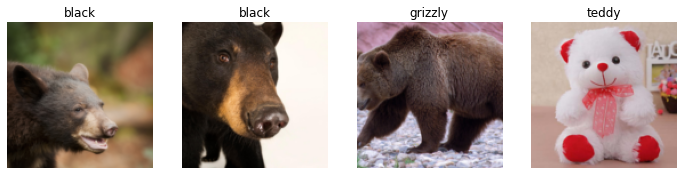

In [40]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

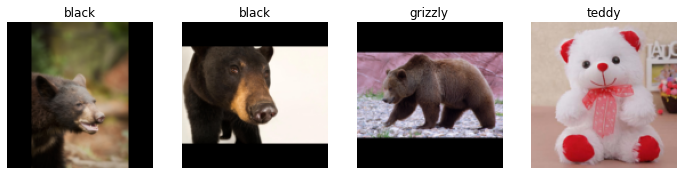

In [41]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

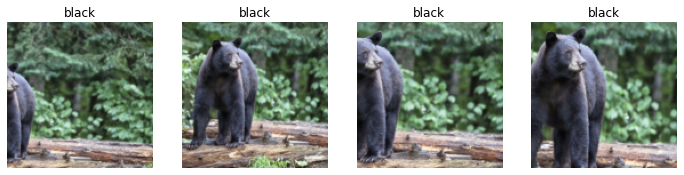

In [42]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

**Data Augmentation**

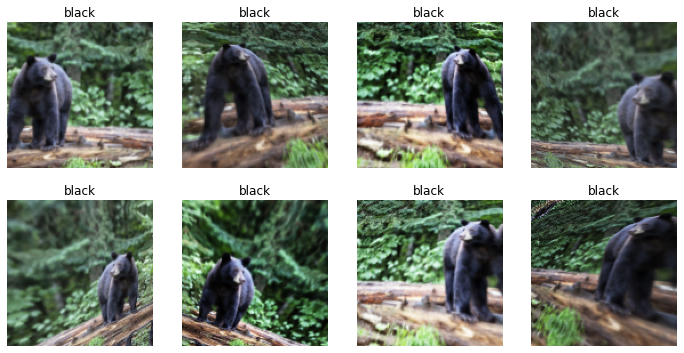

In [43]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

**Training The Model, and Using it to Clear the Data**